In [9]:
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import os
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

In [2]:
game_data = pd.read_csv("../Data/data/clean_game_data.csv",dtype={"p1_id" : "string","p2_id" : "string","p1_char" : "string", "p2_char" : "string", "stage" : "string", "p1_games_played" : "int32", "p1_games_won" : "int32", "p2_games_played" : "int32", "p2_games_won" : "int32", "p1_won" : "bool"})
game_data = pd.get_dummies(game_data, columns=["p1_char","p2_char","stage"], prefix_sep=".", )
game_data

,p1_id,p2_id,p1_won,p1_games_played,p1_games_won,p2_games_played,p2_games_won,p1_char.-1,p1_char.banjokazooie,p1_char.bayonetta,...,stage.Town and City,stage.Unova Pokemon League,stage.Unova Pokémon League,stage.Venom,stage.WarioWare,stage.Wily Castle,stage.Yggdrasil's Altar,stage.Yoshi's Island,stage.Yoshi's Island (Melee),stage.Yoshi's Story
0,1472816,1075251,False,2,0,23,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1075251,1472816,True,23,13,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,challonge__MrRiceman,challonge__Loconotcoco,False,4,1,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Leo,1272809,True,1,1,102,49,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1034645,1302612,True,77,40,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2963854,30896,4702,False,72,51,865,555,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2963855,4702,30896,True,865,555,72,51,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2963856,1263104,53481,True,186,112,8,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2963857,53481,1263104,False,8,7,186,112,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In `sklearn`, there aren't recipes. Instead, there are pipelines, which works a bit like a recipe and a workflow combined. We can apply transformations to our data including selecting predictors, normalizing variables, and adding models.

In [3]:
game_train, game_test = train_test_split(game_data, train_size = 0.8, stratify = game_data[["p1_won"]], random_state=2049)

# We stratified on our response, p1_won. 
# This shouldn't make too much of a difference because we randomized which is p1 and p2, however it is still good practice.

X = game_train.loc[:,game_train.columns != "p1_won"]
y = game_train["p1_won"]

game_folded = StratifiedKFold(n_splits=5).split(X,y)

Let's start by using our numerical predictors to fit a linear model. We want to use a logistic regression because we are predicting a binary class. We're going to score by accuracy because there is no class imbalance present (because we randomized p1_won) and accuracy is much easier to interpret.

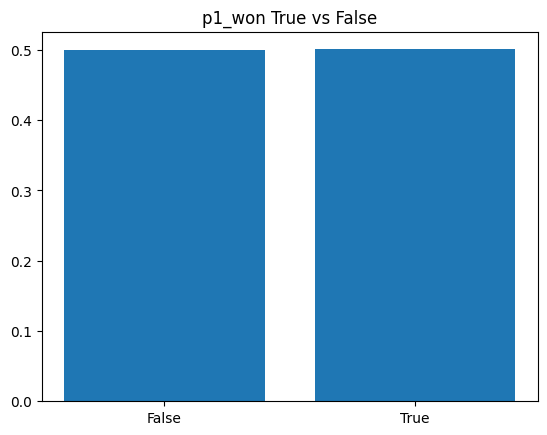

In [4]:
plt.bar(x = [True, False], height = game_train["p1_won"].value_counts() / len(game_train))
plt.xticks([True, False], ["True", "False"])
plt.title("p1_won True vs False")
plt.show()

In [5]:
def fitmodel(model, filename, df = game_train):
    
    if not os.path.isfile(filename):

        model.fit(X,y)

        joblib.dump(model, filename)

    else:
        modeltemp = joblib.load(filename)
        if (type(model) != type(modeltemp)) or \
            (tuple([k[0] for k in model.steps]) != tuple([k[0] for k in modeltemp.steps])):
            print ("\033[93m Warning: model mismatch. Delete the file {filename} and rerun or risk faulty models.\n \033[0m".format(filename=filename))
        model = modeltemp
    return model


First let's fit a logistic regression with no penalty. For this and the elastic net, we'll just use the numerical predictors.

In [13]:
lm_predictors = ["p1_games_played","p2_games_played","p1_games_won","p2_games_won"]

lm_pipe = Pipeline(steps = [
    ("predictors", ColumnTransformer([("predictors","passthrough",lm_predictors)])),
    ("logistic", linear_model.LogisticRegression(penalty=None))
    ])

game_folded = StratifiedKFold(n_splits=5).split(X,y)

lm_cross_val = cross_val_score(estimator = lm_pipe,
                               cv = game_folded,
                               scoring = 'accuracy',
                               X = X,
                               y = y,
                               verbose = 3)

print("%0.4f accuracy with a standard deviation of %0.4f." % (lm_cross_val.mean(), lm_cross_val.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.643) total time=   3.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] END ................................ score: (test=0.643) total time=   2.9s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV] END ................................ score: (test=0.642) total time=   2.7s
[CV] END ................................ score: (test=0.645) total time=   2.6s
[CV] END ................................ score: (test=0.643) total time=   2.9s
0.6433 accuracy with a standard deviation of 0.0007.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.8s finished


In [28]:
lm = fitmodel(model = lm_pipe,
              filename = "models/logistic_regression.joblib")

Now we're going to use an elastic net and tune the parameter `l1_ratio`, which gives the proportion of lasso regression to ridge regression. A value of `1.0` is expressed as a lasso regression, `0.0` is expressed as a ridge regression, and anything in between is some sort of elastic net. 

We can also tune C, a hyperparameter which controls penalty strength.

In [73]:
en_predictors = ["p1_games_played","p2_games_played","p1_games_won","p2_games_won"]

en_pipe = Pipeline(steps = [
    ("predictors", ColumnTransformer([("predictors","passthrough",en_predictors)])),
    ("logistic", linear_model.LogisticRegression(solver='saga',penalty='elasticnet'))
    ])

en_grid = dict(logistic__l1_ratio = [0.0, 0.10, 0.25, 0.50, 0.75, 0.90, 1.0],
               logistic__C = [1000, 100, 10, 1.0, 0.1, 0.01, 0.001])

game_folded = StratifiedKFold(n_splits=5).split(X,y)

en_grid_search = GridSearchCV(estimator = en_pipe,
                            param_grid = en_grid,
                            n_jobs = 1,
                            cv = game_folded,
                            scoring = 'accuracy',
                            error_score = 0,
                            verbose = 4)

In [74]:
en_grid_result = en_grid_search.fit(X[en_predictors],y) # We pass in X[en_predictors] because the result is the same but slightly faster.

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5] END logistic__C=1000, logistic__l1_ratio=0.0;, score=0.679 total time=   7.2s
[CV 2/5] END logistic__C=1000, logistic__l1_ratio=0.0;, score=0.679 total time=   7.2s
[CV 3/5] END logistic__C=1000, logistic__l1_ratio=0.0;, score=0.679 total time=   7.1s
[CV 4/5] END logistic__C=1000, logistic__l1_ratio=0.0;, score=0.681 total time=   7.7s
[CV 5/5] END logistic__C=1000, logistic__l1_ratio=0.0;, score=0.680 total time=   7.0s
[CV 1/5] END logistic__C=1000, logistic__l1_ratio=0.1;, score=0.679 total time=   7.2s
[CV 2/5] END logistic__C=1000, logistic__l1_ratio=0.1;, score=0.679 total time=   7.3s
[CV 3/5] END logistic__C=1000, logistic__l1_ratio=0.1;, score=0.679 total time=   7.2s
[CV 4/5] END logistic__C=1000, logistic__l1_ratio=0.1;, score=0.681 total time=   7.3s
[CV 5/5] END logistic__C=1000, logistic__l1_ratio=0.1;, score=0.680 total time=   7.3s


KeyboardInterrupt: 

In [100]:
print("C = {bestC}, l1_ratio = {bestratio}, with an accuracy of {bestScore}.\n".format(
    bestC = en_grid_result.best_params_['logistic__C'],
    bestratio = en_grid_result.best_params_['logistic__l1_ratio'],
    bestScore = en_grid_result.best_score_))

res = pd.DataFrame(en_grid_result.cv_results_)
print(res[['param_logistic__l1_ratio','param_logistic__C','mean_test_score']])

C = 0.01, l1_ratio = 1.0, with an accuracy of 0.6431155838173498.

   param_logistic__l1_ratio param_logistic__C  mean_test_score
0                       0.0              1000         0.643111
1                       0.1              1000         0.643091
2                      0.25              1000         0.643102
3                       0.5              1000         0.643092
4                      0.75              1000         0.643100
5                       0.9              1000         0.643089
6                       1.0              1000         0.643097
7                       0.0               100         0.643077
8                       0.1               100         0.643110
9                      0.25               100         0.643108
10                      0.5               100         0.643092
11                     0.75               100         0.643105
12                      0.9               100         0.643094
13                      1.0               100      

In [60]:
en_pipe.set_params(logistic__C = 0.01, logistic__l1_ratio = 1.0)
en = fitmodel(model = en_pipe,
              filename = "models/elastic_net.joblib")

One thing to keep in mind is that games played and games won are relative to the size of the dataset, so it might be a good idea to use a proportion between players instead in case someone wants to use the final model on a dataset which is not of the same size. It's unclear if this will matter though.

The goal of this project is more interpretation/inference than predicition, so we can hold this thought for now.

In [15]:
dtc_predictors = list(set(game_train.head()).difference({"p1_won","p1_id","p2_id"}))

dtc_pipe = Pipeline(steps = [
    ("predictors", ColumnTransformer([("predictors","passthrough",dtc_predictors)])),
    ("decision_tree", tree.DecisionTreeClassifier(random_state = 42))
    ])

dtc_grid = dict(decision_tree__ccp_alpha = [0.000, 0.005, 0.010, 0.020],
                decision_tree__max_depth = [3, 5, 10, None],
                decision_tree__min_samples_leaf = [1, 3, 5, 10])

game_folded = StratifiedKFold(n_splits=5).split(X,y)

dtc_grid_search = GridSearchCV(estimator = dtc_pipe,
                               param_grid = dtc_grid,
                               n_jobs = 4,
                               cv = game_folded,
                               scoring = 'accuracy',
                               error_score = 0,
                               verbose = 10)

In [121]:
dtc_grid_result = dtc_grid_search.fit(X[dtc_predictors],y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


KeyboardInterrupt: 

In [ ]:
print("Max Features = {bestccp}, Max Depth = {bestMD}, Min Samples Leaf = {bestMS}, with an accuracy of {bestScore}.\n".format(
    bestccp = dtc_grid_result.best_params_['decision_tree__ccp_alpha'],
    bestMD = dtc_grid_result.best_params_['decision_tree__max_depth'],
    bestMS = dtc_grid_result.best_params_['decision_tree__min_samples_leaf'],
    bestScore = dtc_grid_result.best_score_))

res = pd.DataFrame(dtc_grid_result.cv_results_)
print(res[['param_decision_tree__max_features',
           'param_decision_tree__max_depth',
           'param_decision_tree__min_samples_leaf',
           'mean_test_score']])

Max Features = None, Max Depth = 10, Min Samples Leaf = 10, with an accuracy of 0.646869980057419.

   param_decision_tree__max_features param_decision_tree__max_depth  \
0                               sqrt                              3   
1                               sqrt                              3   
2                               sqrt                              3   
3                               sqrt                              3   
4                               log2                              3   
5                               log2                              3   
6                               log2                              3   
7                               log2                              3   
8                               None                              3   
9                               None                              3   
10                              None                              3   
11                              None            

In [16]:
dtc_pipe.set_params(decision_tree__max_features = None, decision_tree__max_depth = 10, decision_tree__min_samples_leaf = 10)

dtc = fitmodel(model = dtc_pipe,
               filename = "models/decision_tree.joblib")

In [18]:
cross_val_score(dtc, cv = 2, X=X, y=y, verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.646) total time=  24.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.9s remaining:    0.0s


[CV] END ................................ score: (test=0.648) total time=  24.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.7s finished


array([0.64642898, 0.64808025])

In [8]:
rfc_predictors = list(set(game_train.head()).difference({"p1_won","p1_id","p2_id"}))

rfc_pipe = Pipeline(steps = [
            ("predictors", ColumnTransformer([("predictors","passthrough",rfc_predictors)])),
            ("random_forest", ensemble.RandomForestClassifier(verbose = 3, n_jobs = 4, random_state = 420))
            ])

rfc_grid = dict(random_forest__n_estimators = [100,200,400],
                random_forest__min_samples_leaf = [1, 3, 5, 10])

game_folded = StratifiedKFold(n_splits=2).split(X,y) # 5 folds takes a LONG time to run...

rfc_grid_search = GridSearchCV(estimator = rfc_pipe,
                               param_grid = rfc_grid,
                               n_jobs = 1,
                               cv = game_folded,
                               scoring = 'accuracy',
                               error_score = 0,
                               verbose = 10)

In [9]:
rfc_grid_results = rfc_grid_search.fit(X,y)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2; 1/12] START random_forest__min_samples_leaf=1, random_forest__n_estimators=100


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   21.9s finished


[CV 1/2; 1/12] END random_forest__min_samples_leaf=1, random_forest__n_estimators=100;, score=0.664 total time= 5.0min
[CV 2/2; 1/12] START random_forest__min_samples_leaf=1, random_forest__n_estimators=100


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  4.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   21.3s finished


[CV 2/2; 1/12] END random_forest__min_samples_leaf=1, random_forest__n_estimators=100;, score=0.665 total time= 4.6min
[CV 1/2; 2/12] START random_forest__min_samples_leaf=1, random_forest__n_estimators=200


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  8.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   32.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   50.7s finished


[CV 1/2; 2/12] END random_forest__min_samples_leaf=1, random_forest__n_estimators=200;, score=0.666 total time= 9.5min
[CV 2/2; 2/12] START random_forest__min_samples_leaf=1, random_forest__n_estimators=200


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  8.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   49.6s finished


[CV 2/2; 2/12] END random_forest__min_samples_leaf=1, random_forest__n_estimators=200;, score=0.667 total time= 9.4min
[CV 1/2; 3/12] START random_forest__min_samples_leaf=1, random_forest__n_estimators=400


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   58.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 11.4min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed: 16.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   34.4s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:  1.9min finished


[CV 1/2; 3/12] END random_forest__min_samples_leaf=1, random_forest__n_estimators=400;, score=0.667 total time=18.6min
[CV 2/2; 3/12] START random_forest__min_samples_leaf=1, random_forest__n_estimators=400


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 12.4min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed: 17.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   33.5s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:  1.9min finished


[CV 2/2; 3/12] END random_forest__min_samples_leaf=1, random_forest__n_estimators=400;, score=0.668 total time=19.7min
[CV 1/2; 4/12] START random_forest__min_samples_leaf=3, random_forest__n_estimators=100


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   55.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   12.1s finished


[CV 1/2; 4/12] END random_forest__min_samples_leaf=3, random_forest__n_estimators=100;, score=0.672 total time= 4.0min
[CV 2/2; 4/12] START random_forest__min_samples_leaf=3, random_forest__n_estimators=100


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   54.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.7s finished


[CV 2/2; 4/12] END random_forest__min_samples_leaf=3, random_forest__n_estimators=100;, score=0.672 total time= 4.0min
[CV 1/2; 5/12] START random_forest__min_samples_leaf=3, random_forest__n_estimators=200


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   54.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  7.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   23.4s finished


[CV 1/2; 5/12] END random_forest__min_samples_leaf=3, random_forest__n_estimators=200;, score=0.672 total time= 7.9min
[CV 2/2; 5/12] START random_forest__min_samples_leaf=3, random_forest__n_estimators=200


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   53.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  7.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   23.9s finished


[CV 2/2; 5/12] END random_forest__min_samples_leaf=3, random_forest__n_estimators=200;, score=0.673 total time= 7.8min
[CV 1/2; 6/12] START random_forest__min_samples_leaf=3, random_forest__n_estimators=400


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   54.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 10.3min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed: 14.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   33.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:   47.2s finished


[CV 1/2; 6/12] END random_forest__min_samples_leaf=3, random_forest__n_estimators=400;, score=0.672 total time=15.6min
[CV 2/2; 6/12] START random_forest__min_samples_leaf=3, random_forest__n_estimators=400


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   54.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 10.3min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed: 14.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   14.4s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   34.0s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:   48.3s finished


[CV 2/2; 6/12] END random_forest__min_samples_leaf=3, random_forest__n_estimators=400;, score=0.674 total time=15.6min
[CV 1/2; 7/12] START random_forest__min_samples_leaf=5, random_forest__n_estimators=100


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   10.2s finished


[CV 1/2; 7/12] END random_forest__min_samples_leaf=5, random_forest__n_estimators=100;, score=0.670 total time= 3.8min
[CV 2/2; 7/12] START random_forest__min_samples_leaf=5, random_forest__n_estimators=100


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   51.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   10.2s finished


[CV 2/2; 7/12] END random_forest__min_samples_leaf=5, random_forest__n_estimators=100;, score=0.671 total time= 3.8min
[CV 1/2; 8/12] START random_forest__min_samples_leaf=5, random_forest__n_estimators=200


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   51.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  7.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   20.4s finished


[CV 1/2; 8/12] END random_forest__min_samples_leaf=5, random_forest__n_estimators=200;, score=0.670 total time= 7.4min
[CV 2/2; 8/12] START random_forest__min_samples_leaf=5, random_forest__n_estimators=200


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   51.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  7.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   20.3s finished


[CV 2/2; 8/12] END random_forest__min_samples_leaf=5, random_forest__n_estimators=200;, score=0.671 total time= 7.4min
[CV 1/2; 9/12] START random_forest__min_samples_leaf=5, random_forest__n_estimators=400


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   51.7s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  9.8min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed: 14.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   28.4s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:   40.5s finished


[CV 1/2; 9/12] END random_forest__min_samples_leaf=5, random_forest__n_estimators=400;, score=0.670 total time=14.8min
[CV 2/2; 9/12] START random_forest__min_samples_leaf=5, random_forest__n_estimators=400


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   52.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 10.1min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed: 14.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   27.4s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:   38.9s finished


[CV 2/2; 9/12] END random_forest__min_samples_leaf=5, random_forest__n_estimators=400;, score=0.672 total time=15.1min
[CV 1/2; 10/12] START random_forest__min_samples_leaf=10, random_forest__n_estimators=100


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   48.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.6s finished


[CV 1/2; 10/12] END random_forest__min_samples_leaf=10, random_forest__n_estimators=100;, score=0.666 total time= 3.5min
[CV 2/2; 10/12] START random_forest__min_samples_leaf=10, random_forest__n_estimators=100


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   49.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.5s finished


[CV 2/2; 10/12] END random_forest__min_samples_leaf=10, random_forest__n_estimators=100;, score=0.667 total time= 3.6min
[CV 1/2; 11/12] START random_forest__min_samples_leaf=10, random_forest__n_estimators=200


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   50.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  6.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   18.1s finished


[CV 1/2; 11/12] END random_forest__min_samples_leaf=10, random_forest__n_estimators=200;, score=0.666 total time= 7.2min
[CV 2/2; 11/12] START random_forest__min_samples_leaf=10, random_forest__n_estimators=200


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   51.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  6.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   18.1s finished


[CV 2/2; 11/12] END random_forest__min_samples_leaf=10, random_forest__n_estimators=200;, score=0.668 total time= 7.2min
[CV 1/2; 12/12] START random_forest__min_samples_leaf=10, random_forest__n_estimators=400


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   48.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed: 13.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   25.2s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:   35.8s finished


[CV 1/2; 12/12] END random_forest__min_samples_leaf=10, random_forest__n_estimators=400;, score=0.667 total time=13.8min
[CV 2/2; 12/12] START random_forest__min_samples_leaf=10, random_forest__n_estimators=400


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   48.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed: 13.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   25.6s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:   36.8s finished


[CV 2/2; 12/12] END random_forest__min_samples_leaf=10, random_forest__n_estimators=400;, score=0.668 total time=13.8min


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 2 of 400building tree 1 of 400
building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.0min


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 10.1min


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 23.5min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400


[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed: 33.4min finished


In [14]:
print("Number of Trees = {bestn}, Min Samples Leaf = {bestMS}, with an accuracy of {bestScore}.\n".format(
    bestn = rfc_grid_results.best_params_['random_forest__n_estimators'],
    bestMS = rfc_grid_results.best_params_['random_forest__min_samples_leaf'],
    bestScore = rfc_grid_results.best_score_))

res = pd.DataFrame(rfc_grid_results.cv_results_)
print(res[['param_random_forest__n_estimators',
           'param_random_forest__min_samples_leaf',
           'mean_test_score']])

Number of Trees = 400, Min Samples Leaf = 3, with an accuracy of 0.67308622613204.

   param_random_forest__n_estimators param_random_forest__min_samples_leaf  \
0                                100                                     1   
1                                200                                     1   
2                                400                                     1   
3                                100                                     3   
4                                200                                     3   
5                                400                                     3   
6                                100                                     5   
7                                200                                     5   
8                                400                                     5   
9                                100                                    10   
10                               200                      

Despite 400 trees having the highest mean test score, it is only by .00035, and is computationally twice as expensive as 200 trees, which itself is only higher than 100 trees by .0007. We can always use a higher number of trees to get a marginally better test score, so with discretion, I am going to use 200 trees with min_samples_leaf = 3.

In [20]:
rfc_pipe.set_params(random_forest__n_estimators = 200, random_forest__min_samples_leaf = 3)

rfc = fitmodel(model = rfc_pipe,
               filename = "models/random_forest.joblib")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200building tree 2 of 200
building tree 3 of 200

building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200building tree 26 of 200

building tree 27 of 200
building tree 28 of 200


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.1min


building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200building tree 67 of 200

building tree 68 of 200
building tree 69 of 200
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 10.2min


building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200building tree 139 of 200

building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 16.9min finished


In [21]:
ensemble.GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Want to tune max_depth and min_samples_leaf, as well as learning rate and n_estimators.

In [30]:
train_sample = game_train.sample(50000, random_state= 49)

X_sample = train_sample.loc[:,game_train.columns != "p1_won"]
y_sample = train_sample["p1_won"]

gbc_predictors = list(set(game_train.head()).difference({"p1_won","p1_id","p2_id"}))

gbc_pipe = rfc_pipe = Pipeline(steps = [
            ("predictors", ColumnTransformer([("predictors","passthrough",gbc_predictors)])),
            ("boosted_tree", ensemble.GradientBoostingClassifier(verbose = 1, n_estimators = 100, random_state = 21))
            ])

gbc_grid = dict(boosted_tree__n_estimators = [100, 250, 500, 1000],
                boosted_tree__max_depth = [2, 3, 4, 5],
                boosted_tree__min_samples_leaf = [1, 3, 5, 10],
                boosted_tree__learning_rate = [.001, .01, .1, .2]
                )

game_folded = StratifiedKFold(n_splits=2).split(X_sample,y_sample)

gbc_grid_search = GridSearchCV(estimator = gbc_pipe,
                               param_grid = gbc_grid,
                               n_jobs = 4,
                               cv = game_folded,
                               scoring = 'accuracy',
                               error_score = 0,
                               verbose = 10)

In [31]:
gbc_grid_result = gbc_grid_search.fit(X_sample,y_sample)

Fitting 2 folds for each of 256 candidates, totalling 512 fits
      Iter       Train Loss   Remaining Time 
         1           1.3616           44.13s
         2           1.3431           43.19s
         3           1.3287           43.32s
         4           1.3179           43.34s
         5           1.3090           43.02s
         6           1.3011           43.19s
         7           1.2958           42.79s
         8           1.2904           42.81s
         9           1.2858           42.56s
        10           1.2822           42.46s
        20           1.2637           40.95s
        30           1.2553           39.72s
        40           1.2471           38.85s
        50           1.2409           37.98s
        60           1.2352           37.08s
        70           1.2307           36.12s
        80           1.2281           35.15s
        90           1.2235           34.39s
       100           1.2191           33.65s
       200           1.1873         

In [40]:
print("Number of trees = {bestn}, Learning Rate = {bestLR}, Min Samples Leaf = {bestMS}, Max Depth = {bestMD}, with an accuracy of {bestScore}.\n".format(
    
    bestn = gbc_grid_result.best_params_['boosted_tree__n_estimators'],
    bestLR = gbc_grid_result.best_params_['boosted_tree__learning_rate'],
    bestMS = gbc_grid_result.best_params_['boosted_tree__min_samples_leaf'],
    bestMD = gbc_grid_result.best_params_['boosted_tree__max_depth'],
    bestScore = gbc_grid_result.best_score_))

res = pd.DataFrame(gbc_grid_result.cv_results_)

print(res[['param_boosted_tree__max_depth',
           'mean_test_score']])

Number of trees = 500, Learning Rate = 0.2, Min Samples Leaf = 3, Max Depth = 2, with an accuracy of 0.66928.

    param_boosted_tree__max_depth  mean_test_score
0                               2          0.59228
1                               2          0.61034
2                               2          0.61558
3                               2          0.62490
4                               2          0.59228
..                            ...              ...
251                             5          0.64458
252                             5          0.66192
253                             5          0.65880
254                             5          0.65242
255                             5          0.64436

[256 rows x 2 columns]


In [37]:
gbc_pipe.set_params(boosted_tree__max_depth = 2, boosted_tree__n_estimators = 500, boosted_tree__learning_rate = 0.2, boosted_tree__min_samples_leaf = 3)

game_folded = StratifiedKFold(n_splits=2).split(X,y)

cross_val_score(estimator = gbc_pipe,
                n_jobs = 1,
                cv = game_folded,
                X = X,
                y = y,
                scoring = 'accuracy',
                error_score = 0,
                verbose = 10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
      Iter       Train Loss   Remaining Time 
         1           1.3621           23.91m
         2           1.3448           23.38m
         3           1.3310           23.14m
         4           1.3204           22.77m
         5           1.3115           22.75m
         6           1.3045           22.63m
         7           1.2986           22.67m
         8           1.2936           22.69m
         9           1.2896           22.59m
        10           1.2856           22.41m
        20           1.2676           21.82m
        30           1.2599           21.31m
        40           1.2544           20.72m
        50           1.2505           20.15m
        60           1.2452           19.67m
        70           1.2382           19.26m
        80           1.2328           18.83m
        90           1.2292           18.35m
       100           1.2258           17.89m
       200        

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 22.6min remaining:    0.0s


      Iter       Train Loss   Remaining Time 
         1           1.3624           22.61m
         2           1.3443           22.70m
         3           1.3312           22.63m
         4           1.3205           22.58m
         5           1.3122           22.32m
         6           1.3051           22.37m
         7           1.2992           22.19m
         8           1.2944           22.17m
         9           1.2900           21.99m
        10           1.2861           21.95m
        20           1.2679           21.44m
        30           1.2606           20.97m
        40           1.2558           20.41m
        50           1.2520           20.18m
        60           1.2453           20.61m
        70           1.2409           20.76m
        80           1.2355           20.08m
        90           1.2300           19.50m
       100           1.2257           18.93m
       200           1.2020           13.77m
       300           1.1908            9.05m
       40

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 44.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 44.9min finished


array([0.67963905, 0.68006475])

In [42]:
gbc_pipe.set_params(boosted_tree__max_depth = 2, boosted_tree__n_estimators = 500, boosted_tree__learning_rate = 0.2, boosted_tree__min_samples_leaf = 3)

fitmodel(gbc_pipe,
         "models/boosted_tree.joblib")

      Iter       Train Loss   Remaining Time 
         1           1.3623           56.47m
         2           1.3443           56.16m
         3           1.3310           55.41m
         4           1.3203           54.68m
         5           1.3117           54.45m
         6           1.3051           53.95m
         7           1.2988           53.86m
         8           1.2940           53.94m
         9           1.2896           53.57m
        10           1.2861           53.53m
        20           1.2681           51.82m
        30           1.2603           50.35m
        40           1.2540           49.12m
        50           1.2494           47.65m
        60           1.2463           46.23m
        70           1.2417           45.08m
        80           1.2380           43.85m
        90           1.2343           42.83m
       100           1.2297           41.87m
       200           1.2018           31.85m
       300           1.1908           21.15m
       40

Pipeline(steps=[('predictors',
                 ColumnTransformer(transformers=[('predictors', 'passthrough',
                                                  ['p1_char.wiifittrainer',
                                                   'p1_char.roy',
                                                   'p1_char.metaknight',
                                                   'stage.New Donk City Hall',
                                                   'p1_char.pichu',
                                                   'p2_char.simon',
                                                   'p2_char.-1',
                                                   'stage.Green Greens',
                                                   'p1_char.random',
                                                   'p1_char.diddykong',
                                                   'p1_char.olimar',
                                                   'p2_char.wario',
                                                   'p1_char.snake',
                                                   'p1_char.hero',
                                                   'p2_char.h...
                                                   'p2_char.peach',
                                                   'p1_char.ridley',
                                                   'p2_char.younglink',
                                                   'stage.Eldin Bridge',
                                                   'stage.Find Mii',
                                                   'stage.Kalos Pokemon League',
                                                   'p2_char.pit',
                                                   'p2_char.joker',
                                                   'p1_char.ganondorf',
                                                   'p2_char.terry',
                                                   'p1_char.cloud',
                                                   'p1_char.littlemac', ...])])),
                ('boosted_tree',
                 GradientBoostingClassifier(learning_rate=0.2, max_depth=2,
                                            min_samples_leaf=3,
                                            n_estimators=500, random_state=21,
                                            verbose=1))])